# Regional price index formation
This is used to calculate regional price index for non-tradeable goods. This is needed to calculate regional real wages

General strategy: Get quaertly inflation numbers, use base price levels for the differention regions, calculate prices levels overtime using the quaertly inflation numbers

#### Not sure what this is doing

In [1]:
import sys
from pathlib import Path

p = Path.cwd().resolve()
repo_root = next((parent for parent in [p] + list(p.parents) if (parent / ".git").exists()), None)
if repo_root is None:
    raise RuntimeError("Repo root not found. Open the repo folder in VS Code.")

sys.path.insert(0, str(repo_root))
print("Repo root:", repo_root)

Repo root: C:\Users\maxah\OneDrive\2. Imperial\3. 3rd Year\4. Final project\1. FP_code\Group_Project_Y3


#### Load in data and files

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#import price data
regional_prices_path = repo_root / "raw" / "00_regional_price" / "region_price.csv"
inflation = pd.read_csv(regional_prices_path,sep=';')

#### Convert into a clean data frame in long format

#### Functions

In [4]:
#function for cleaner the column headers
def clean_header(col_name):
    if "quarter" not in col_name.lower():
        return col_name # Keep index columns as they are
    
    # Split by semicolon: ["quarter 1", "total - ...", "2024", "[-]"]
    parts = col_name.split(';')
    
    # Extract pieces
    quarter = parts[0].strip().replace('quarter ', 'Q') # "quarter 1" -> "Q1"
    category = parts[1].split(' - ')[0].strip()        # "total - previous..." -> "total"
    year = parts[2].strip()                            # "2024"
    
    # Return a combined string we can split later
    return f"{category}|{quarter}_{year}"


#function to convert quarter-year string to datetime
def to_date(qy_str):
    q, year = qy_str.split('_')
    # Map Quarters to the first month of that quarter
    month_map = {'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}
    return pd.to_datetime(f"{year}-{month_map[q]}-01")


#### Implementation
This leaves us with a clean long dataframe

In [5]:
# Rename the columns
inflation.columns = [clean_header(c) for c in inflation.columns]

#melt the dataframe into long format
id_cols = [c for c in inflation.columns if '|' not in c] # columns like 'Country' or 'ID'
inflation_long = inflation.melt(id_vars=id_cols, var_name='Metadata', value_name='Value')
#split the heading names into separate columns
inflation_long[['category', 'quarter_year']] = inflation_long['Metadata'].str.split('|', expand=True)

#convert quarter-year string to datetime
inflation_long['Date'] = inflation_long['quarter_year'].apply(to_date)

#final Clean up
inflation_final = inflation_long.drop(columns=['Metadata'])

In [6]:
inflation_final['Name'].unique()

array(['POLAND', 'DOLNOŚLĄSKIE', 'KUJAWSKO-POMORSKIE', 'LUBELSKIE',
       'LUBUSKIE', 'ŁÓDZKIE', 'MAŁOPOLSKIE', 'MAZOWIECKIE', 'OPOLSKIE',
       'PODKARPACKIE', 'PODLASKIE', 'POMORSKIE', 'ŚLĄSKIE',
       'ŚWIĘTOKRZYSKIE', 'WARMIŃSKO-MAZURSKIE', 'WIELKOPOLSKIE',
       'ZACHODNIOPOMORSKIE'], dtype=object)

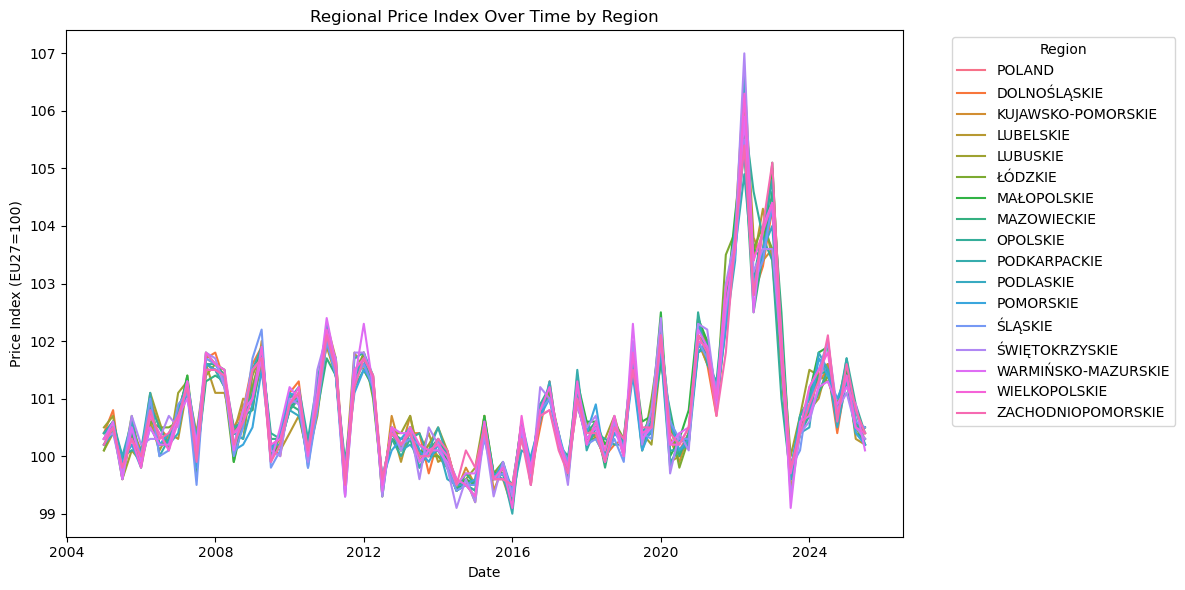

In [7]:
plt.figure(figsize=(12,6))
sns.lineplot(data=inflation_final[inflation_final['category'] == 'total'], x='Date', y='Value', hue='Name')
plt.title('Regional Price Index Over Time by Region')
plt.ylabel('Price Index (EU27=100)')
plt.xlabel('Date')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# House data

In [8]:
regional_house_path = repo_root / "raw" / "00_regional_price" / "house_transactions.csv"
houses_wide = pd.read_csv(regional_house_path,sep=';')

In [9]:
id_cols = ['Code', 'Name']

houses_long = houses_wide.melt(id_vars=id_cols, var_name='Metadata', value_name='Price_PLN')

def extract_date_info(row):
    parts = str(row['Metadata']).split(';')
    
    # Check if we have enough parts (at least 4 for index [3])
    if len(parts) >= 4:
        # "quarter 1" -> "Q1"
        quarter = parts[0].strip().replace('quarter ', 'Q')
        # "2010" is at index 3
        year = parts[3].strip()
        return pd.Series([quarter, year])
    else:
        # Return placeholders if the format doesn't match
        return pd.Series([None, None])

houses_long[['Quarter', 'Year']] = houses_long.apply(extract_date_info, axis=1)

houses_long['Quarter_Year'] = houses_long['Quarter'] + '_' + houses_long['Year']
houses_long.dropna(subset=['Quarter_Year'], inplace=True)

houses = houses_long.drop(columns=['Metadata'])

# Convert to the nullable integer type (supports NA)
houses['Year'] = pd.to_numeric(houses['Year'], errors='coerce').astype('Int64')
houses['Date'] = houses['Quarter_Year'].apply(to_date)

#final formatting
houses = houses.sort_values(by=['Date', 'Name']).reset_index(drop=True)
houses = houses[houses['Year'] != 2025]

# Generating the index
Take some average of the housing index for each pow over the last 8 years (rough time of a real estate cycle) pre 2021. Use this as the baseline price level, then grow this at the selected inflation rate of the non-tradebale goods, weighted by the importance of these aspects in the household expenditure survey

#### The baseline starting
Uisng the housing data to create a baseline which we will then grow using CPI data

In [10]:
upper = 2021
lower  = 2010

houses_pre_2021 = houses[(houses['Year'] > lower) & (houses['Year'] < upper)].reset_index(drop=True)
avg_prices_pre_2021 = houses_pre_2021.groupby(['Name','Code'])['Price_PLN'].mean().reset_index()

#some windowizing to remove extreme outliers
avg_prices_pre_2021 = avg_prices_pre_2021[avg_prices_pre_2021['Price_PLN'] < avg_prices_pre_2021['Price_PLN'].quantile(0.999)]
avg_prices_pre_2021 = avg_prices_pre_2021[avg_prices_pre_2021['Price_PLN'] > avg_prices_pre_2021['Price_PLN'].quantile(0.001)] 


avg_prices_pre_2021.sort_values(by='Price_PLN', ascending=False)

,Name,Code,Price_PLN
324,Powiat tatrzański,1217000,8307.225
5,City with powiat status Capital City Warszawa,1465000,8282.775
70,MAZOWIECKIE,1400000,6846.275
24,City with powiat status Kraków,1261000,6734.900
12,City with powiat status Gdynia,2262000,6332.200
...,...,...,...
139,Powiat górowski,204000,777.250
323,Powiat tarnowski,1216000,661.275
370,Powiat łomżyński,2007000,647.700
192,Powiat lipski,1409000,523.200


In [11]:
#set to out of 100 with 100 being Poland average
poland_avg = avg_prices_pre_2021[avg_prices_pre_2021['Name'] == 'POLAND']['Price_PLN'].iloc[0]
avg_prices_pre_2021['Price_Index'] = (avg_prices_pre_2021['Price_PLN'] / poland_avg) * 100

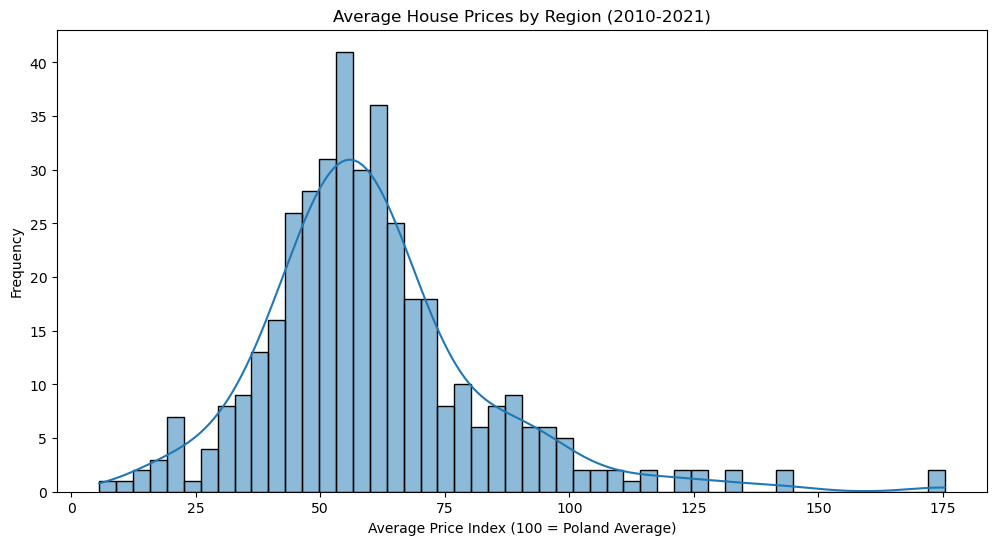

In [12]:
plt.figure(figsize=(12,6))
sns.histplot(data=avg_prices_pre_2021, x='Price_Index', bins=50, kde=True)
plt.title(f'Average House Prices by Region ({lower}-{upper})')
plt.xlabel('Average Price Index (100 = Poland Average)')
plt.ylabel('Frequency')
plt.show()

#### Add the viodship

In [13]:
#create the viodship code column for merging with the inflation data

# Convert to string and pad with leading zeros until the length is 7
houses['Code'] = houses['Code'].astype(str).str.zfill(7)
houses['Viodship_code'] = houses['Code'].astype(str).str[:2]
houses['quarter_year'] = houses['Quarter_Year']

#inflation data
inflation_final['Code'] = inflation_final['Code'].astype(str).str.zfill(7)
inflation_final['Viodship_code'] = inflation_final['Code'].astype(str).str[:2]

#merge data on viodship and quarter-year
price_levels = pd.merge(houses, inflation_final, on=['Viodship_code', 'quarter_year'], how='inner')

#keep only the relevant columns
price_levels = price_levels[['Code_x', 'Name_x','Price_PLN','quarter_year','Date_x','Viodship_code','Value','category']]
price_levels.rename(columns={'Code_x': 'Code', 'Name_x': 'Name', 'quarter_year': 'Quarter_Year', 'Date_x': 'Date', 'Value': 'Price_Index', 'category': 'Inflation_Category','Price_PLN':'House_price_PLN'}, inplace=True)

#index price levels for houes to 100
price_levels['House_Price_Index'] = (price_levels['House_price_PLN'] / poland_avg) * 100

#### Calculate inflation rate

In [14]:
#filter out tradeable good inflation
price_levels['Inflation_Category'].unique()

#our defintion ot non tradeable good
non_tradeable = ['dwelling', 'health']

#filter out tradeable good inflation
price_levels_non_tradable = price_levels[price_levels['Inflation_Category'].isin(non_tradeable)].reset_index(drop=True)

#calculate inflation rates for non tradeable goods

price_levels_non_tradable = price_levels_non_tradable.sort_values(['Code', 'Inflation_Category', 'Date'])

price_levels_non_tradable['inflation_rate'] = price_levels_non_tradable['Price_Index'] - 100

# 2. Group by the entities and calculate the percentage change
price_levels_non_tradable['house_inflation_rate'] = (
    price_levels_non_tradable.groupby(['Code', 'Inflation_Category'])['House_price_PLN']
    .pct_change() * 100
)
price_levels_non_tradable.head()

,Code,Name,House_price_PLN,Quarter_Year,Date,Viodship_code,Price_Index,Inflation_Category,House_Price_Index,inflation_rate,house_inflation_rate
792,0000000,POLAND,4508.0,Q1_2010,2010-01-01,00,101.5,dwelling,95.156677,1.5,NaN
1586,0000000,POLAND,4527.0,Q2_2010,2010-04-01,00,100.7,dwelling,95.557737,0.7,0.421473
2380,0000000,POLAND,4515.0,Q3_2010,2010-07-01,00,100.5,dwelling,95.304436,0.5,-0.265076
3174,0000000,POLAND,4655.0,Q4_2010,2010-10-01,00,100.9,dwelling,98.259612,0.9,3.100775
3968,0000000,POLAND,4481.0,Q1_2011,2011-01-01,00,102.8,dwelling,94.586750,2.8,-3.737916


In [15]:
#weight inflation rates by the share of non-tradeable goods in total inflation

#weight create weight columns
dwelling = 0.2
house = 0.5
health = 1 - (dwelling + house)


price_levels_non_tradable['dwelling_weight'] = price_levels_non_tradable.apply(
    lambda row:dwelling if row['Inflation_Category'] == 'dwelling' else 0, axis=1)

price_levels_non_tradable['health_weight'] = price_levels_non_tradable.apply(
    lambda row:health if row['Inflation_Category'] == 'health' else 0, axis=1)


price_levels_non_tradable['house_weight'] = price_levels_non_tradable.apply(
    lambda row:health if row['Inflation_Category'] == 'house' else 0, axis=1)

price_levels_non_tradable['weighted_inflation'] = (price_levels_non_tradable['inflation_rate'] * price_levels_non_tradable['dwelling_weight']) + (
                                                        price_levels_non_tradable['inflation_rate'] * price_levels_non_tradable['health_weight']) +(
                                                        price_levels_non_tradable['house_inflation_rate'] * price_levels_non_tradable['house_weight'])

inflation_non_tradeable = price_levels_non_tradable.groupby(['Code', 'Date'])['weighted_inflation'].sum().reset_index()

inflation_non_tradeable.head()

,Code,Date,weighted_inflation
0,0000000,2010-01-01,0.00
1,0000000,2010-04-01,0.41
2,0000000,2010-07-01,0.31
3,0000000,2010-10-01,0.30
4,0000000,2011-01-01,1.01


Weights for each section come from their relevant factor on the household budget survey

#### Create the final inflation time series

In [16]:
avg_prices_pre_2021['Code'] = avg_prices_pre_2021['Code'].astype(str).str.zfill(7)

#grow the original price levels dataframe with the non-tradeable inflation data
inflation_time_series = avg_prices_pre_2021.merge(inflation_non_tradeable, left_on='Code', right_on='Code', how='left')

#sort values
inflation_time_series = inflation_time_series.sort_values(['Code', 'Date'])

#generate multiplier column for growth calculation
inflation_time_series['multiplier'] = 1 + (inflation_time_series['weighted_inflation'] / 100)
inflation_time_series['cum_growth'] = (inflation_time_series.groupby('Code')['multiplier'].cumprod()
)


inflation_time_series['Non_tradeable_Price_Index'] = (
    inflation_time_series.groupby('Code')['Price_Index'].transform('first') * inflation_time_series['cum_growth']
)
inflation_time_series.head()

#keep only the relevant columns
inflation_time_series = inflation_time_series.drop(columns=['multiplier'])

inflation_time_series.head()

,Name,Code,Price_PLN,Price_Index,Date,weighted_inflation,cum_growth,Non_tradeable_Price_Index
4440,POLAND,0000000,4737.45,100.0,2010-01-01,0.00,1.000000,100.000000
4441,POLAND,0000000,4737.45,100.0,2010-04-01,0.41,1.004100,100.410000
4442,POLAND,0000000,4737.45,100.0,2010-07-01,0.31,1.007213,100.721271
4443,POLAND,0000000,4737.45,100.0,2010-10-01,0.30,1.010234,101.023435
4444,POLAND,0000000,4737.45,100.0,2011-01-01,1.01,1.020438,102.043772


### Plot to check it looks okay
We should not see that much variation with Poland (I think) and should follow general trends

In [17]:
inflation_final = inflation_final.sort_values(['Code', 'Date'])
inflation_final['Inflation_rate'] = inflation_final['Value'] - 100

inflation_final.head()

,Code,Name,Unnamed: 758,Value,category,quarter_year,Date,Viodship_code,Inflation_rate
0,0000000,POLAND,NaN,100.3,total,Q1_2005,2005-01-01,00,0.3
357,0000000,POLAND,NaN,100.5,food and non-alcoholic beverages,Q1_2005,2005-01-01,00,0.5
714,0000000,POLAND,NaN,100.2,"alcoholic beverages, tobacco",Q1_2005,2005-01-01,00,0.2
1071,0000000,POLAND,NaN,97.0,clothing and footwear,Q1_2005,2005-01-01,00,-3.0
1428,0000000,POLAND,NaN,101.2,dwelling,Q1_2005,2005-01-01,00,1.2


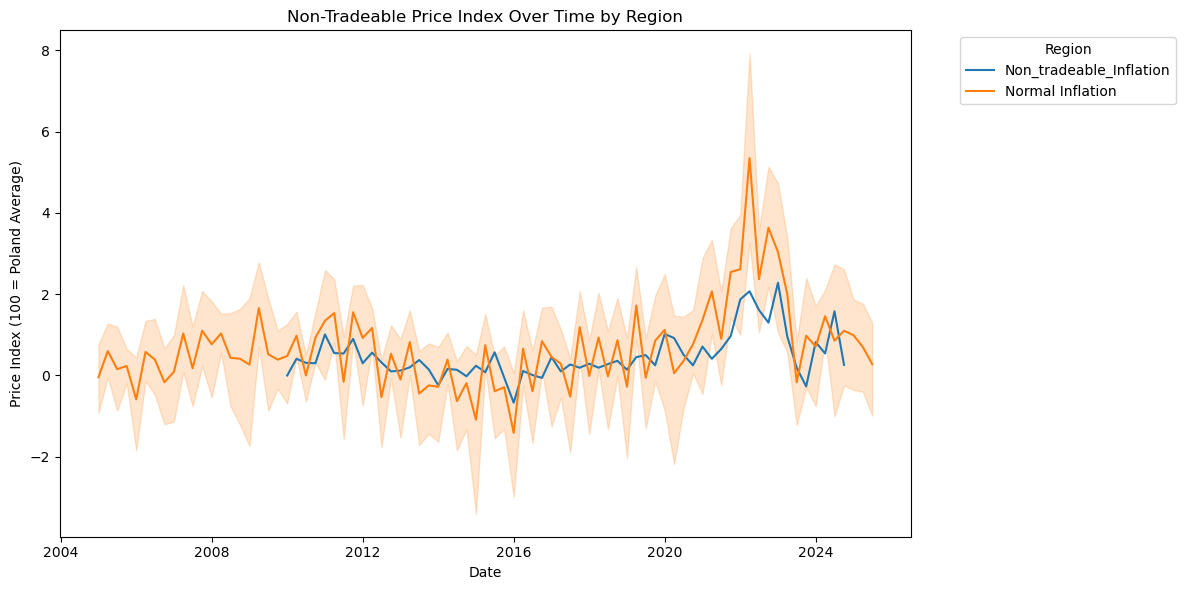

In [18]:
plt.figure(figsize=(12,6))

sns.lineplot(data=inflation_time_series[inflation_time_series['Name'] == 'POLAND'], x='Date', y='weighted_inflation', 
             label ='Non_tradeable_Inflation')

sns.lineplot(data=inflation_final[inflation_final['Name'] == 'POLAND'], x='Date', y='Inflation_rate', 
             label='Normal Inflation')

plt.title('Non-Tradeable Price Index Over Time by Region')
plt.ylabel('Price Index (100 = Poland Average)')
plt.xlabel('Date')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

Looks decent to me

In [19]:
inflation_time_series_final = inflation_time_series.rename(columns={'weighted_inflation': 'Non_tradeable_Inflation', 
                                                                    'Price_PLN': 'House_Price_Index',
                                                                    'Price_Index' : 'Regional_Price_Index (prev period = 100)'})

In [20]:
#output the final data
inflation_time_series_final .to_csv(repo_root / "cleaned" / "00_non_trade_prices" / "non_tradeable_inflation_time_series.csv", index=False)

# Turns out this method did not work at all
Leads to all very simmilar results

# Price levels

In [21]:
#load in GDP data
regional_GDP_current_path = repo_root / "raw" / "00_regional_GDP" / "GDP_current_prices.csv"
regional_GDP_PPS_path = repo_root / "raw" / "00_regional_GDP" / "GDP_PPS.csv"

GDP_current_wide = pd.read_csv(regional_GDP_current_path,sep=';')

#pps formating
GDP_PPS = pd.read_csv(regional_GDP_PPS_path)
GDP_PPS = GDP_PPS[['Unit of measure','TIME_PERIOD','OBS_VALUE','Geopolitical entity (reporting)']]

GDP_PPS = GDP_PPS.rename(columns={'TIME_PERIOD': 'Year', 'OBS_VALUE': 'GDP_PPS', 'Geopolitical entity (reporting)': 'Name'})
GDP_PPS = GDP_PPS.drop(columns=['Unit of measure'])
GDP_PPS = GDP_PPS.sort_values(['Name', 'Year'])
GDP_PPS['Name'] = GDP_PPS['Name'].str.upper()
GDP_PPS.head()

,Year,GDP_PPS,Name
60,2014,20500,DOLNOŚLĄSKIE
61,2015,21700,DOLNOŚLĄSKIE
62,2016,21900,DOLNOŚLĄSKIE
63,2017,22900,DOLNOŚLĄSKIE
64,2018,24000,DOLNOŚLĄSKIE


In [22]:
#GDP current prices formatting
id_cols = ['Code', 'Name']

def clean_gdp_headers(col):
    if col in id_cols:
        return col
    
    # Split by semicolon and extract the year (usually the second part)
    parts = col.split(';')
    if len(parts) >= 2:
        # Extract just the year (e.g., '2000')
        return parts[1].strip()
    return col

GDP_current_wide.columns = [clean_gdp_headers(c) for c in GDP_current_wide.columns]


GDP_current = GDP_current_wide.melt(
    id_vars=id_cols, 
    var_name='Year', 
    value_name='GDP_Per_Capita_PLN'
)

#conver into final data frame
GDP_current['Year'] = pd.to_numeric(GDP_current['Year'], errors='coerce')
GDP_current = GDP_current.dropna(subset=['Year']).astype({'Year': int})


#### Calculate price index for each year

In [23]:
GDP_PPS['Name'].unique()

array(['DOLNOŚLĄSKIE', 'KUJAWSKO-POMORSKIE', 'LUBELSKIE', 'LUBUSKIE',
       'MAZOWIECKI REGIONALNY', 'MAŁOPOLSKIE', 'OPOLSKIE', 'PODKARPACKIE',
       'PODLASKIE', 'POLAND', 'POMORSKIE', 'WARMIŃSKO-MAZURSKIE',
       'WARSZAWSKI STOŁECZNY', 'WIELKOPOLSKIE', 'ZACHODNIOPOMORSKIE',
       'ŁÓDZKIE', 'ŚLĄSKIE', 'ŚWIĘTOKRZYSKIE'], dtype=object)

In [24]:
GDP_current['Name'].unique()

array(['POLAND', 'DOLNOŚLĄSKIE', 'KUJAWSKO-POMORSKIE', 'LUBELSKIE',
       'LUBUSKIE', 'ŁÓDZKIE', 'MAŁOPOLSKIE', 'MAZOWIECKIE', 'OPOLSKIE',
       'PODKARPACKIE', 'PODLASKIE', 'POMORSKIE', 'ŚLĄSKIE',
       'ŚWIĘTOKRZYSKIE', 'WARMIŃSKO-MAZURSKIE', 'WIELKOPOLSKIE',
       'ZACHODNIOPOMORSKIE'], dtype=object)

<Axes: xlabel='Year', ylabel='Price_Index'>

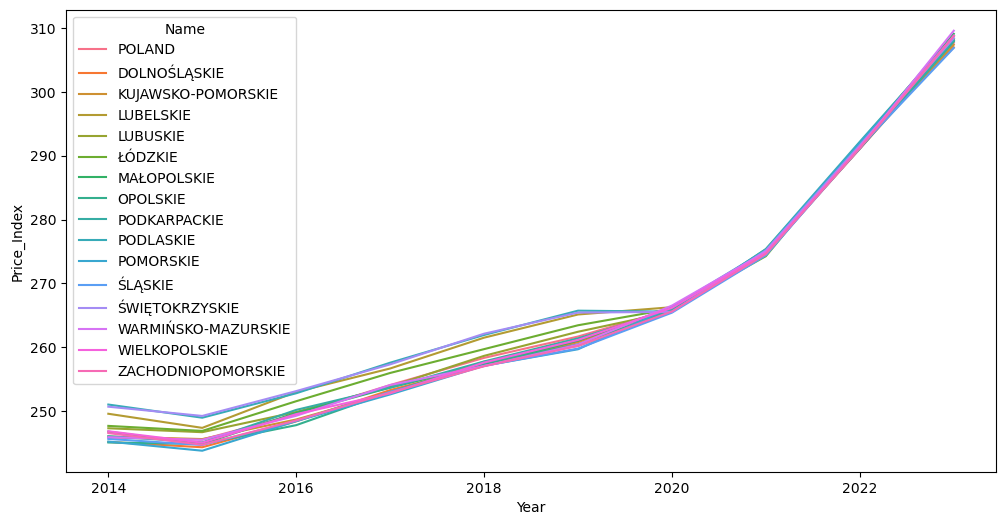

In [25]:
#merge into one dataframe
GDP_all = pd.merge(GDP_current, GDP_PPS, on=['Name', 'Year'], how='inner')

#calculate price index
GDP_all['Price_Index'] = (GDP_all['GDP_Per_Capita_PLN'] / GDP_all['GDP_PPS']) * 100

plt.figure(figsize=(12,6))
sns.lineplot(data=GDP_all, x='Year', y='Price_Index', hue='Name')


<BarContainer object of 16 artists>

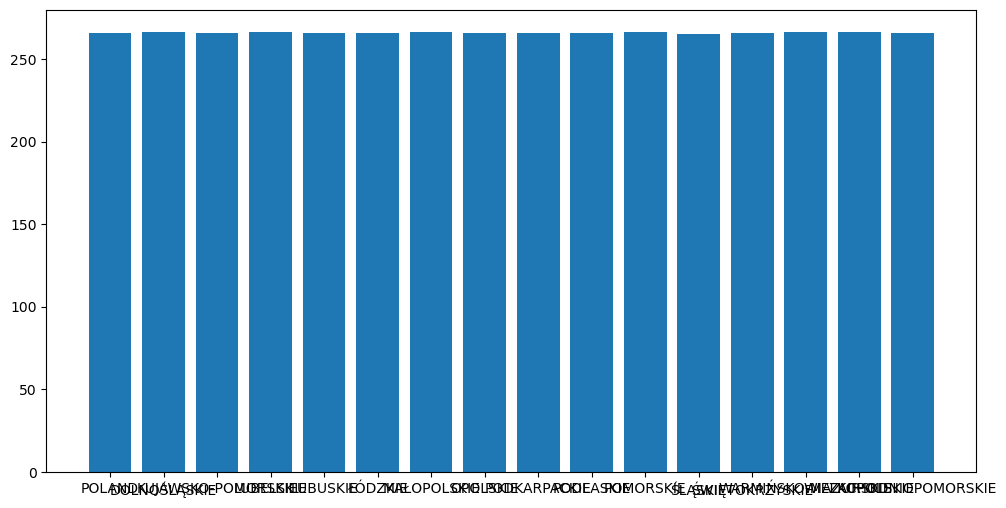

In [26]:
GDP_all_fil = GDP_all[GDP_all['Year'] == 2020]

plt.figure(figsize=(12,6))
plt.bar(GDP_all_fil['Name'], GDP_all_fil['Price_Index'])

In [27]:
GDP_all_fil.sort_values('Price_Index', ascending=False)

,Code,Name,Year,GDP_Per_Capita_PLN,GDP_PPS,Price_Index
109,2800000,WARMIŃSKO-MAZURSKIE,2020,46112.0,17300,266.543353
106,2200000,POMORSKIE,2020,59384.0,22300,266.295964
99,600000,LUBELSKIE,2020,45003.0,16900,266.289941
102,1200000,MAŁOPOLSKIE,2020,57503.0,21600,266.217593
110,3000000,WIELKOPOLSKIE,2020,68144.0,25600,266.187500
97,200000,DOLNOŚLĄSKIE,2020,69460.0,26100,266.130268
101,1000000,ŁÓDZKIE,2020,61458.0,23100,266.051948
96,0,POLAND,2020,63577.0,23900,266.012552
104,1800000,PODKARPACKIE,2020,45460.0,17100,265.847953
103,1600000,OPOLSKIE,2020,51572.0,19400,265.835052
